In [1]:
%load_ext autoreload
%autoreload 2
import os
import cv2
import json
import pandas as pd

from datetime import datetime

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from myutil import Parameters
import models
import dataloader
import losses

params = Parameters('parameters.json')
model = models.hybrid_network

TIME_FORMAT = datetime.now().strftime('%h-%d-%Y-%Hh%Mm%Ss')

In [2]:
train_path = ''
valid_path = ''

class_names_path = ''

# Read in class names
with open(class_names_path) as file:
    class_names = json.load(file)
class_names


# Get the paths to the raw image files and put them in an array
train_files = []

# Iterate through data folder directory recursively
for root, directories, filenames in os.walk(train_path):
    # Only get images (in subfolders)
    if not root == train_path:
        for filename in filenames:
            if filename.endswith('.jpg'):
                train_files.append(os.path.join(root, filename))

train_identifiers = [r.split('/')[-2] for r in train_files]

train_labels = np.zeros((len(train_files), len(class_names)))
for i, identifier in enumerate(train_identifiers):
    for key in class_names:
        if key in identifier:
            train_labels[i, class_names[key]] = 1

train_value_counts = dict()
for key in class_names:
    train_value_counts[key] = [train_labels[:, class_names[key]].sum()]
    
    
# Get the paths to the raw image files and put them in an array
valid_files = []

# Iterate through data folder directory recursively
for root, directories, filenames in os.walk(valid_path):
    # Only get images (in subfolders)
    if not root == valid_path:
        for filename in filenames:
            if filename.endswith('.jpg'):
                valid_files.append(os.path.join(root, filename))

valid_identifiers = [r.split('/')[-2] for r in valid_files]

valid_labels = np.zeros((len(valid_files), len(class_names)))
for i, identifier in enumerate(valid_identifiers):
    for key in class_names:
        if key in identifier:
            valid_labels[i, class_names[key]] = 1

valid_value_counts = dict()
for key in class_names:
    valid_value_counts[key] = [valid_labels[:, class_names[key]].sum()]

In [3]:
if params.IMAGE_SIZE == 'AUTO':
    params.IMAGE_SIZE = cv2.imread(train_files[0]).shape[:2]
    
if params.N_CLASSES == 'AUTO':
    params.N_CLASSES = len(class_names)

print("Number of classes: {n_classes}".format(n_classes=params.N_CLASSES))
print('Train size: {train_size}\nValid_size: {valid_size}\nImage size: {image_size}'.format(train_size=len(train_files),
                                                                                             valid_size=len(valid_files),
                                                                                             image_size=params.IMAGE_SIZE))


df = pd.concat([pd.DataFrame(train_value_counts).T, pd.DataFrame(valid_value_counts).T], axis=1)
df.columns = ['train', 'valid']
df = df.sort_values('train')
print(df)

# valid_class_counts = pd.value_counts(valid_labels).sort_index().values

# Resample for training
multiplicity = 2

to_sample = df.index[:1]
train_labels_resampled = list(train_labels)
train_files_resampled = [x for x in train_files]
for i in range(len(train_labels)):
    if not np.prod(train_labels[i] == np.array([0, 0])):
        for _ in range(multiplicity):
            train_labels_resampled.append(train_labels[i])
            train_files_resampled.append(train_files[i])

Number of classes: 2
Train size: 95723
Valid_size: 2340
Image size: (128, 128)
                    train   valid
power_substation   7135.0   104.0
storage_tank      35471.0  1943.0


/home/GOLDLNK/jonathan.shuai/anaconda3/envs/clean/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


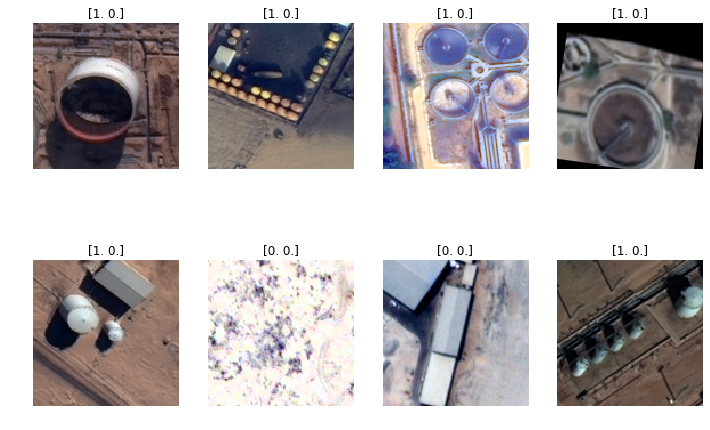

In [ ]:
transforms = [
                dataloader.RandomFlip(),
                dataloader.RandomBrightness(-20, 20),
                dataloader.Blur(),
                dataloader.ColorJitter(), 
                dataloader.RandomAffine(),
                dataloader.RandomRotate()
             ]
transformer = dataloader.Transformer(transforms, apply_prob=1.0)

train_dataloader = dataloader.DataLoader(train_files_resampled, train_labels_resampled, 
                                         batch_size=params.BATCH_SIZE, 
                                         image_size=params.IMAGE_SIZE, 
                                         transformer=transformer,
#                                          preprocessor=preprocessor
                                        )

valid_dataloader = dataloader.DataLoader(valid_files, valid_labels, 
                                         batch_size=params.BATCH_SIZE, 
                                         image_size=params.IMAGE_SIZE, 
#                                          transformer=transformer,
#                                          preprocessor=preprocessor
                                        )

batch_images, batch_labels = next(train_dataloader.get_data())

plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(list(zip(batch_images, batch_labels))[:8]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    
plt.show()

In [ ]:
# From TensorFlow tutorial
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization).
    """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))

with tf.Graph().as_default() as graph:
    inputs = tf.placeholder(tf.float32, shape=[None, *params.IMAGE_SIZE, 3])
    labels = tf.placeholder(tf.float32, shape=[None, params.N_CLASSES])

    logits = model(inputs, n_classes=params.N_CLASSES)
    
    final_tensor = tf.nn.sigmoid(logits, name='prediction')
    
    # Defining loss function
    with tf.name_scope('loss'):
        loss = -tf.reduce_mean(tf.reduce_sum((labels * tf.log(tf.clip_by_value(final_tensor, 1e-10, 1.0)) \
                    + (1 - labels) * tf.log(tf.clip_by_value(1 - final_tensor, 1e-10, 1.0))), axis=1))
        gradients = tf.gradients(loss, [logits])

    # Accuracy
    with tf.name_scope('accuracy'):
        prediction = tf.cast(tf.math.greater_equal(final_tensor, 0.5), tf.float32)
        equality = tf.equal(prediction, labels)
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))



    # Optimization step
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(params.LEARNING_RATE)
        train_step = optimizer.minimize(loss)

    # Logging
    with tf.name_scope('logging'):
        variable_summaries(logits)
        tf.summary.scalar('current_loss', loss)
        tf.summary.histogram('prediction', prediction)
        summary = tf.summary.merge_all()

In [ ]:
print("Beginning training...")
# Start a session with the graph we created
with tf.Session(graph=graph) as session:
    # Create saver to make checkpoints and save final model
    saver = tf.train.Saver()
    
    if params.SAVE_PATH != '':
        saver.restore(session, params.SAVE_PATH)
    else:    
        # Initialize all weights: for the newly added retraining layer to random initial values.
        init = tf.global_variables_initializer()
        session.run(init)

    # Create the log writers for the summary 
    train_writer = tf.summary.FileWriter("./logs/{}/train".format(params.RUN_NAME), session.graph)
    valid_writer = tf.summary.FileWriter("./logs/{}/valid".format(params.RUN_NAME), session.graph)

    for epoch in range(params.N_EPOCHS):

        print("Epoch {}".format(epoch))
        print("Training...")
        # Training Phase
        running_train_loss = 0
        running_train_acc = 0

        # Get data from our training DataLoader in batches
        for batch_images, batch_labels in train_dataloader.get_data():
            _, train_loss, train_acc, train_summary, train_inputs = session.run(
                [train_step, loss, accuracy, summary, inputs],
                feed_dict={inputs: batch_images, labels: batch_labels})

            running_train_acc += train_acc * train_inputs.shape[0]
            running_train_loss += train_loss

        running_train_acc /= train_dataloader.shape[0]

        print("Validation...")
        # Validation Phase
        running_valid_loss = 0
        running_valid_acc = 0
        
        image_list = []
        label_list = []
        probability_list = []
        prediction_list = []
        # Get data from our validation DataLoader in batches
        for batch_images, batch_labels in valid_dataloader.get_data():
            valid_loss, valid_acc, valid_summary, valid_inputs, valid_prediction, valid_probs = session.run(
                [loss, accuracy, summary, inputs, prediction, final_tensor],
                feed_dict={inputs: batch_images, labels: batch_labels})
            
            image_list.append(batch_images)
            label_list.append(batch_labels)
            probability_list.append(valid_probs)
            prediction_list.append(valid_prediction)
            
            running_valid_acc += valid_acc * valid_inputs.shape[0]
            running_valid_loss += valid_loss

        running_valid_acc /= valid_dataloader.shape[0]

        # Print results of current epoch    
        print("Train loss: {:.2f}\nTrain acc: {:.6f}".format(running_train_loss, 
                                                                running_train_acc))
        print("Valid loss: {:.2f}\nValid acc: {:.6f}".format(running_valid_loss, 
                                                                running_valid_acc))
        print("-" * 10)
        
        truth = np.concatenate(label_list)
        probs = np.concatenate(probability_list)
        preds = np.concatenate(prediction_list)
        images = np.concatenate(image_list)

        for key in class_names:
            plt.figure(figsize=(12, 12))
            cm = confusion_matrix(y_true=truth[:, class_names[key]], y_pred=preds[:, class_names[key]])
            print("---", key, "---")
            print("accuracy score: ", accuracy_score(truth[:, class_names[key]], preds[:, class_names[key]]))
            print("recall score: ", recall_score(truth[:, class_names[key]], preds[:, class_names[key]]))
            print("precision score: ", precision_score(truth[:, class_names[key]], preds[:, class_names[key]]))
            print("f1 score: ", f1_score(truth[:, class_names[key]], preds[:, class_names[key]]))
            sns.heatmap(cm, annot=True)
            plt.title(key)
            plt.show()
        
        select = np.prod(truth == preds, axis=1) == False
        misclassified = images[select]
        truth_m = truth[select]
        preds_m = preds[select]
        assert misclassified.shape[0] == truth_m.shape[0]
        assert misclassified.shape[0] == preds_m.shape[0]
        
        plt.figure(figsize=(12, 12))
        for i, image in enumerate(misclassified[:16]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(image)
            plt.title("Predicted: {}\nActually: {}".format(preds_m[i], truth_m[i]))
            plt.axis('off')
        
        plt.show()
        
        
        # Build on summary
        train_writer.add_summary(train_summary, epoch)
        valid_writer.add_summary(valid_summary, epoch)

        if (epoch % 10 == 0):
            save_path = saver.save(session, "./checkpoints/trained_model_{}.ckpt".format(epoch))
            print("Checkpoint: {}".format(save_path))

    # Save the model
    print("Saving model...")

    save_path = saver.save(session, "./checkpoints/trained_model_final.ckpt")
    print("Model Saved: {}".format(save_path))
    print("Training finished!")

    images = []
    truths = []
    preds = []
    for batch_images, batch_labels in valid_dataloader.get_data():
        valid_preds = session.run(prediction, 
            feed_dict={inputs: batch_images, labels: batch_labels})

        images.extend(batch_images)
        truths.extend(batch_labels)
        preds.extend(valid_preds)

Beginning training...
Epoch 0
Training...


In [ ]:
plt.figure(figsize=(15, 120))
for i, image in enumerate(misclassified[:128]):
    plt.subplot(32, 4, i + 1)
    plt.imshow(image)
    plt.title("Predicted: {}\nActually: {}".format(preds_m[i], truth_m[i]))
    plt.axis('off')

plt.show()